In [1]:
from IPython.display import Image

# 7.1 앙상블 학습


In [2]:

Image(url='https://git.io/JtskW', width=500) 

In [3]:
Image(url='https://git.io/Jtskl', width=500) 


In [6]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error ** k * (1-error) ** (n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [8]:
from scipy.stats import binom

binom.cdf(5, 11, 0.75)

0.03432750701904297

In [10]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]


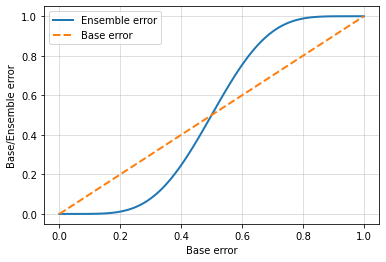

In [11]:
import matplotlib.pyplot as plt

plt.plot(error_range,
        ens_errors,
        label='Ensemble error',
        linewidth=2)

plt.plot(error_range,
        error_range,
        linestyle='--',
        label='Base error',
        linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)

plt.show()

# 7.2 다수결 투표를 사용한 분류 앙상블

### 7.2.1 간단한 다수결 투표 분류기 구현

In [12]:
import numpy as np

np.argmax(np.bincount([0,0,1],
                     weights=[0.2, 0.2, 0.6]))

1

In [17]:
ex = np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])

p = np.average(ex,
              axis=0,
              weights=[0.2, 0.2, 0.6])

p

array([0.58, 0.42])

In [18]:
np.argmax(p)

0

In [ ]:
from sklearn.base import BaseeEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.neamed_classifiers = {key: value for key, value 
                                  in _name_estimators(classifiers)}

        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """